## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

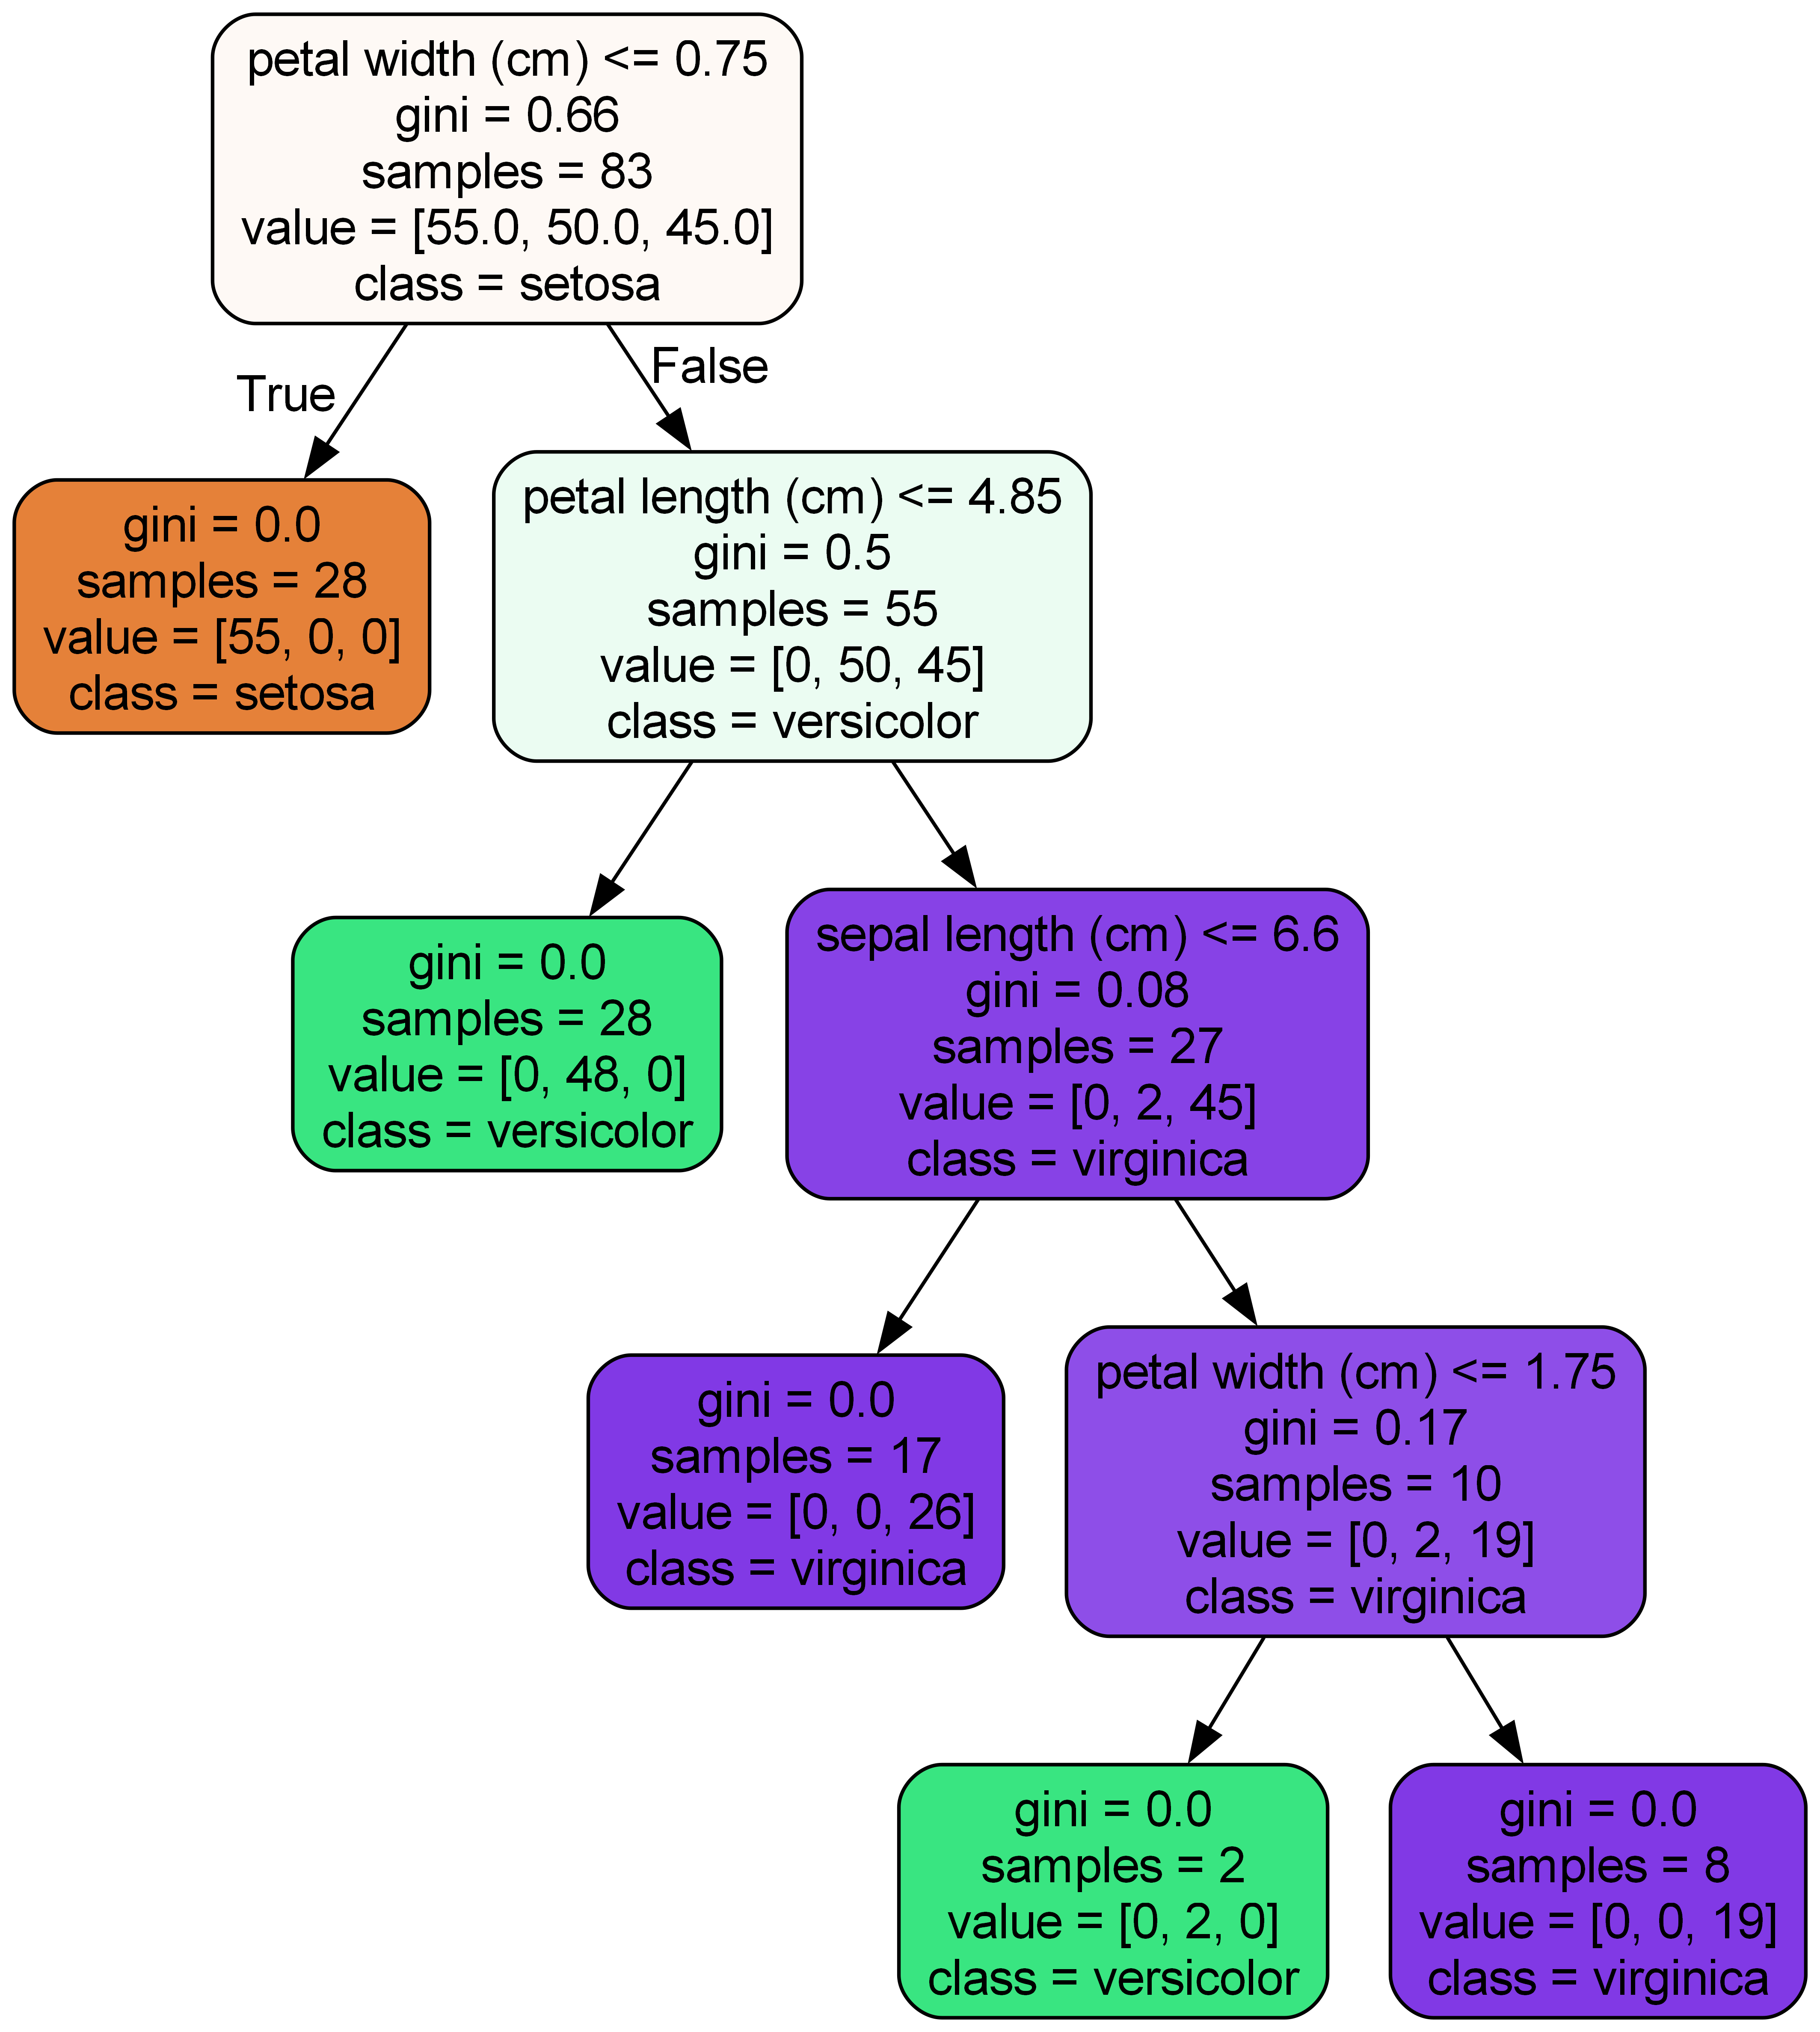

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as mno
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url) 
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['n_age'] = 2020 - df.birth_year
df.loc[df['age'].isnull(),['birth_year', 'age', 'n_age']]


,birth_year,age,n_age
779,1986.0,NaN,34.0
780,1959.0,NaN,61.0
781,1991.0,NaN,29.0
782,1953.0,NaN,67.0
783,2018.0,NaN,2.0
...,...,...,...
1946,NaN,NaN,NaN
1947,NaN,NaN,NaN
2159,NaN,NaN,NaN
2160,NaN,NaN,NaN


n_age = NaN is a result of birth_year = NaN. This will be imputed in the subsequent sections

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [8]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
df['disease'].value_counts()

disease
True    19
Name: count, dtype: int64

In [11]:
df['disease'] = df['disease'].fillna(0)
df['disease'] = df['disease'].apply(lambda x: 1 if x==True else 0)
df['disease'].value_counts()

disease
0    2199
1      19
Name: count, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

Create custom reusable functions

In [12]:
#Custom function for imputing different features (straightforward approach)

def iterative_imputer(df_s, feature, strategy='mean'):
    '''Custom function using IterativeImputer
    Input:
        df_s - working DataFrame
        feature - array of columns of interest
        strategy - mean/median/mode
    Return:
        Values for imputing target feature
    '''
    imputer = IterativeImputer(random_state=123, initial_strategy=strategy)
    imputedcol = imputer.fit_transform(df_s[[feature]])
    return imputedcol

In [13]:
def update_data(df_t, df_s, idx='patient_id', cols_drop=None):
    '''Custom function for updating the working DataFrame with the imputed values
    Input:
        df_t - working DataFrame that will be updated
        df_s - source of update 
        idx - index to set (patient_id) 
        cols_drop - array of columns to drop
    Return:
        A DataFrame containing the updates from dt_s.
    '''
    #Update the df with the imputed values
    df_t.set_index(idx, inplace=True)
    df_t.update(df_s.set_index(idx).drop(cols_drop, axis=1))
    df_t = df_t.reset_index()
    return df_t

In [14]:
#Use iterative_imputer for the features in question (except for birth_year)

feats = ['global_num', 'infection_order','infected_by', 'contact_number' ]
for f in feats:
    imputed = iterative_imputer(df, f, strategy='mean')
    df[f] = imputed.round()

print('Number of null features:' '\n')
df[feats].isna().sum()

Number of null features:



global_num         0
infection_order    0
infected_by        0
contact_number     0
dtype: int64


 
 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

<font color='gray'> <b>Assumption:</b> The [ age ] is the administrator's guess or estimate on the patient's age esp. when birthdate or other personal information can't be obtained or is unavailable.</font>

<font color='gray'>So instead of imputing the patient's [ birth_year ] using the mean of the population [ birth_year ]s or IterativeImputer methods, the [ age ] will be used to estimate the [ birth year ].</font>



<font color='orange'><b>[birth_year]</b></font>

Manually impute [birth_year] based on [n_age]. For this feature, two imputation methods will be used.

In [15]:
# Create a temporary df: no_by - *(no birth year)
# no_by should contain rows with missing birth_year(s) from df

nan_by = df.loc[df.birth_year.isna(), ['patient_id', 'birth_year', 'age','n_age']]

# Store all null birth_year
ct_nan_by = nan_by.birth_year.isna().sum()

# Manually impute n_age in the nan_by df
nan_by['n_age'] = nan_by.age.str.replace('s','').apply(lambda x: float(x)+5 if x!=np.NaN else np.NaN)

# Calculate birth_year in nan_by
nan_by['birth_year'] = 2020 - nan_by.n_age

# Update the original df with records in nan_by
df = update_data(df, nan_by, 'patient_id', 'age')

# Display thew before and after changes
print('(Before Imputer) Null birth_year: ', ct_nan_by )
print('(After Imputer) Null birth_year: ', df.birth_year.isna().sum(), '\n')

# Validate if the null rows under birth_year (same index in nan_by) are now updated based on age
display(df[df.index.isin(nan_by.index)].head() )


(Before Imputer) Null birth_year:  454
(After Imputer) Null birth_year:  151 



,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.0,female,1975.0,40s,Korea,Gwangju,NaN,0,NaN,2.0,2.600789e+09,450.0,2020-01-27,2020-02-04,2020-02-20,NaN,released,45.0
447,1300000002,18.0,female,1995.0,20s,Korea,Gwangju,NaN,0,contact with patient,2.0,1.300000e+09,8.0,NaN,2020-02-05,2020-02-20,NaN,released,25.0
448,1300000003,126.0,male,1985.0,30s,Korea,Gwangju,NaN,0,etc,2.0,2.600789e+09,65.0,NaN,2020-02-20,NaN,NaN,isolated,35.0
449,1300000004,164.0,male,1985.0,30s,Korea,Gwangju,NaN,0,contact with patient,2.0,1.300000e+09,30.0,NaN,2020-02-21,2020-03-18,NaN,released,35.0
450,1300000005,210.0,male,1985.0,30s,Korea,Gwangju,NaN,0,etc,2.0,2.600789e+09,156.0,NaN,2020-02-21,2020-03-16,NaN,released,35.0


Next, check and impute any null birth_years that were not imputed by using the n_age using the iterative_imputer

In [16]:
# Store the count of additional rows to impute
ct_nan_by = df.birth_year.isna().sum()

# Impute the remaining null birth_year using the custom function
df['birth_year'] = iterative_imputer(df, 'birth_year', strategy='mean').round()

# Compare before and after changes
print('(Before Custom IterativeImputer) Null birth_year: ',  ct_nan_by)
print('(After Custom IterativeImputer) Null birth_year: ', df.birth_year.isna().sum())


(Before Custom IterativeImputer) Null birth_year:  151
(After Custom IterativeImputer) Null birth_year:  0


<font color='orange'><b>[n_age]</b></font>

Next, check and impute all other null [n_age] with values from newly-imputed [birth_year]</font>

In [17]:
# Create a temp df: no_n_age - *(No n_age)
nan_n_age = df.loc[df.n_age.isna(), ['patient_id', 'birth_year', 'n_age']]

# Store count of null n_age in df
ct_nan_n_age = df.n_age.isna().sum()

# Calculate n_age based on birth_year
nan_n_age['n_age'] = 2020 - nan_n_age['birth_year']

#Update the original df using no_n_age

# Update the original df with records in nan_by
df = update_data(df, nan_n_age, 'patient_id', 'birth_year')

#Check for null values in n_age
print('(Before Manual Imputation) Null n_age: ', ct_nan_n_age)
print('(After Manual Imputation) Null n_age: ', df.n_age.isna().sum() )


(Before Manual Imputation) Null n_age:  151
(After Manual Imputation) Null n_age:  0


Impute remaining [n_age]


In [18]:
#Create a temp df: no_age - *(No age)
# Extract the empty [age] rows in df
nan_age = df.loc[df.age.isna(), ['patient_id', 'birth_year', 'age', 'n_age']]

# Store count of null age in df
ct_nan_age = df.age.isna().sum()

# Manually impute using n_age calculated previously
nan_age['age'] = nan_age['n_age'].apply(lambda x: str((x)/10).split('.')[0] + '0s' )


#Update the df with the imputed values in nan_age
df = update_data(df, nan_age, 'patient_id', ['birth_year', 'n_age'])

print('Before Manual imputation) Null age: ', ct_nan_age )
print('After Manual Imputation) Null age: ', df.age.isna().sum() )


Before Manual imputation) Null age:  261
After Manual Imputation) Null age:  0


 **<font color='teal'> Check for any remaining null values.</font>**

<Axes: >

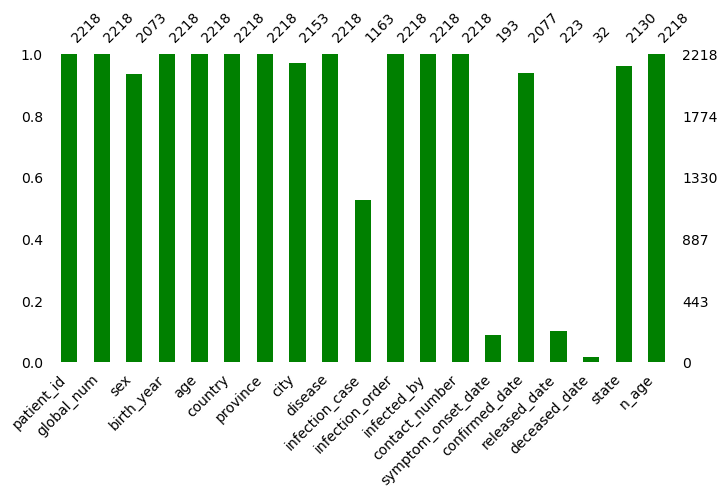

In [19]:
mno.bar(df, figsize = (8, 4), fontsize=10, color='green')

<font color='orange'><b> [sex] </b>

Impute sex column

In [20]:
# Create a new column [n_sex] and map sex/gender with binary numbers
# Store null count of [sex]
ct_nan_sex =  df.sex.isna().sum()

dict_sex = {'male':1, 'female':0}
df['n_sex'] = df.sex.map(dict_sex)

display(df.sex.value_counts())

sex
female    1171
male       902
Name: count, dtype: int64

In [21]:
# Use KNN Imputer to impute missing sex_map
knn_imp = KNNImputer(n_neighbors=1)

imputed = knn_imp.fit_transform(df[['n_age', 'n_sex']])
df['n_sex'] = imputed[:,1]
df['sex'] = df['n_sex'].replace(dict_sex.values(), dict_sex.keys())
df.sex.value_counts()

sex
female    1314
male       904
Name: count, dtype: int64

<font color='orange'><b> [city] </b>

Impute city

In [22]:
# Display the count of cities in each province
df.groupby(['country', 'province'])['city'].size()

country   province         
China     Busan                   1
          Gangwon-do              1
          Gyeonggi-do             4
          Incheon                 1
          Seoul                   3
Korea     Busan                 100
          Chungcheongbuk-do      28
          Chungcheongnam-do     118
          Daegu                  63
          Daejeon                22
          Gangwon-do             28
          Gwangju                18
          Gyeonggi-do           295
          Gyeongsangbuk-do     1053
          Gyeongsangnam-do       85
          Incheon                31
          Jeju-do                 4
          Jeollabuk-do            7
          Jeollanam-do            4
          Sejong                 41
          Seoul                 279
          Ulsan                  30
Mongolia  Gyeonggi-do             1
Thailand  Gyeongsangbuk-do        1
Name: city, dtype: int64

A simple Google search of the provinces listed under the countries China, Mongolia, and Thailand reveals that they are all from South Korea. 

In [23]:
# Apply correction on country
df['country'] = df['country'].apply(lambda c: 'Korea' if c!='Korea' else c)
df.groupby(['country', 'province'], dropna=False)['city'].size()

country  province         
Korea    Busan                 101
         Chungcheongbuk-do      28
         Chungcheongnam-do     118
         Daegu                  63
         Daejeon                22
         Gangwon-do             29
         Gwangju                18
         Gyeonggi-do           300
         Gyeongsangbuk-do     1054
         Gyeongsangnam-do       85
         Incheon                32
         Jeju-do                 4
         Jeollabuk-do            7
         Jeollanam-do            4
         Sejong                 41
         Seoul                 282
         Ulsan                  30
Name: city, dtype: int64

In [24]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

In [25]:
def label_encoder(idf, cat_lbl, enc_lbl):
    '''This function creates a new column that encodes the categorical label. 
    Then, original Null rows in the categorical label are assigned NaN in the target encoded label. 
    Arguments:
        idf = working DataFrame
        cat_lbl = catetgorical label to be encoded
        enc_lbl = target column for the encoded numeric value. 
    Return:
        A dictionary containing the mapping of the categorical label and the encoded label
    '''
    
    le = preprocessing.LabelEncoder()
    le.fit(idf.loc[:, cat_lbl])
    df[enc_lbl] =  le.transform(df[cat_lbl])    

    # Store the mapping for return later
    lbl_mapping = dict(zip(le.classes_, le.transform(le.classes_ )))

     # Change back to NaN all transformed values of NaN in the target encoded label. 
    idf[enc_lbl] = idf[enc_lbl].apply(lambda x: np.NaN if x == lbl_mapping.get(np.nan) else x)
    
    return lbl_mapping

In [26]:
#Use label_encoder to encode categorical labels into encoded labels, and to get the appropriate mapping

map_countries = label_encoder(df, 'country', 'n_ctry')
map_provinces = label_encoder(df, 'province', 'n_prov')
map_cities = label_encoder(df, 'city', 'n_city')


In [27]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,n_sex,n_ctry,n_prov,n_city
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,...,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1.0,0,15,34.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,...,NaN,2020-01-30,2020-03-02,NaN,released,33.0,1.0,0,15,76.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,...,NaN,2020-01-30,2020-02-19,NaN,released,56.0,1.0,0,15,74.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,...,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,1.0,0,15,77.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,...,NaN,2020-01-31,2020-02-24,NaN,released,28.0,0.0,0,15,99.0


In [28]:
def iterative_imputer_estimator(idf, itr_feats=[], iestimator = None, irand=123):
    '''
    Iterative Imputer with estimator parameter.
    Input: 
        idf - working DataFrame
        itr_feats - array of features
        iestimator - estimator of choice (DecisionTreeClassifier, RandomForestClassifier, etc.)
        irand - random_state number for replication
    Output:
        Imputed values
    '''
    
    iter_imputer = IterativeImputer(random_state = irand, estimator=iestimator)
    iter_imputer.fit(idf.loc[:, itr_feats])
    return iter_imputer.transform(idf.loc[:, itr_feats])

In [29]:
# Use the custom imputer, and modify the n_estimator parameter accordingly.
feats = ['n_ctry', 'n_prov', 'n_city']
imputed = iterative_imputer_estimator(df, feats, DecisionTreeClassifier(), 123)
df['n_city'] = imputed[:, -1].round(2)

In [30]:
df.n_city.value_counts()

n_city
60.0     535
12.0      98
102.0     89
81.0      67
5.0       60
        ... 
51.0       1
92.0       1
65.0       1
49.0       1
2.0        1
Name: count, Length: 134, dtype: int64

In [31]:
# Save city=NaN rows in df to nan_citites ( for comparison )
nan_cities = df.loc[df.city.isna(), :] 

print('Provices with NaN cities')
nan_cities.groupby(['country', 'province', 'city'], dropna=False)['n_city'].size()

Provices with NaN cities


country  province          city
Korea    Busan             NaN      1
         Daegu             NaN     42
         Gwangju           NaN     18
         Gyeongsangnam-do  NaN      3
         Jeollanam-do      NaN      1
Name: n_city, dtype: int64

In [32]:
# Map the imputed n_city to corresponding city in df
df['city'] = df['n_city'].replace(map_cities.values(), map_cities.keys())

#Display updated city in nan_cities
upd_cities = df[df.city.index.isin(nan_cities.index)] 
upd_cities.groupby(['country', 'province', 'city'])['n_city'].size()


country  province          city        
Korea    Busan             Dongnae-gu       1
         Daegu             Nam-gu          42
         Gwangju           Wonju-si        18
         Gyeongsangnam-do  Changwon-si      3
         Jeollanam-do      Gwangyang-si     1
Name: n_city, dtype: int64

<font color='orange'><b>[infection case]</b></font>

Impute infection case

In [33]:
#Know the ranges of infection_case
df.infection_case.value_counts(dropna=False)

infection_case
NaN                                 1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: count, dtype: int64

In [34]:
#Encode the infection_case to a new label
map_icases = label_encoder(df, 'infection_case', 'n_icase')

# Store the number of Nan infection_case
nan_icases = df[df.infection_case.isna()]

nan_icases.groupby('province', dropna=False)['infection_case'].size()

province
Busan                 2
Daegu                49
Gwangju               2
Gyeongsangbuk-do    954
Gyeongsangnam-do     45
Incheon               1
Jeollabuk-do          2
Name: infection_case, dtype: int64

In [35]:
#Impute NaN n_icase
feats = ['n_sex', 'n_age', 'n_ctry', 'n_prov', 'n_city', 'disease', 'n_icase' ]
imputed = iterative_imputer_estimator(df, feats, RandomForestClassifier(), 123)

#Assign the imputed values to n_icase
df['n_icase'] = imputed[:, -1]

# Map the imputed n_icase to the corresponding infection_case in df
df['infection_case'] = df['n_icase'].replace(map_icases.values(), map_icases.keys())

C:\Users\eduar\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [36]:
upd_icases = df[df.infection_case.index.isin(nan_icases.index)]
upd_icases.groupby('province')['infection_case'].count()

province
Busan                 2
Daegu                49
Gwangju               2
Gyeongsangbuk-do    954
Gyeongsangnam-do     45
Incheon               1
Jeollabuk-do          2
Name: infection_case, dtype: int64

<Axes: >

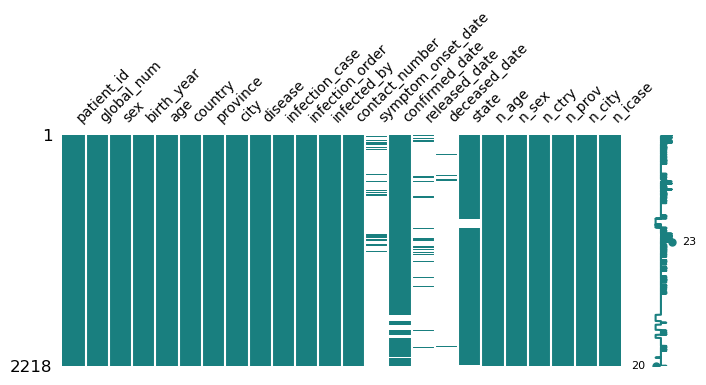

In [37]:
# Check remaining null values
mno.matrix(df, figsize = (8, 3), fontsize=10, color=(0.1, 0.5, 0.5))

<font color='orange'><b>[state]</b></font>

Perform checks on state

In [38]:
#Know the ranges of infection_case
df.state.value_counts(dropna=False)

state
isolated    1791
released     307
NaN           88
deceased      32
Name: count, dtype: int64

In [39]:
nan_states =df.loc[ df['state'].isna()] 
nan_states.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,confirmed_date,released_date,deceased_date,state,n_age,n_sex,n_ctry,n_prov,n_city,n_icase
802,2000000214,8168.0,female,1967.0,50s,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,...,2020-03-15,NaN,NaN,NaN,53.0,0.0,0,7,102.0,11.0
803,2000000215,8195.0,female,1974.0,40s,Korea,Gyeonggi-do,Bucheon-si,0,contact with patient,...,2020-03-15,NaN,NaN,NaN,46.0,0.0,0,7,6.0,11.0
804,2000000216,8212.0,female,1963.0,50s,Korea,Gyeonggi-do,Seongnam-si,0,etc,...,2020-03-15,NaN,NaN,NaN,57.0,0.0,0,7,102.0,12.0
805,2000000217,8205.0,female,1954.0,60s,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,...,2020-03-15,NaN,NaN,NaN,66.0,0.0,0,7,102.0,11.0
806,2000000218,8184.0,female,1992.0,20s,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,...,2020-03-15,NaN,NaN,NaN,28.0,0.0,0,7,102.0,11.0


In [40]:
def display_state_counts(idf, istates):
    ''' A function for displaying each state and its count
    Input:
        idf - working DataFrame
        istates - array of states
    Return: None
    '''
    dict_states = {}
    for state in istates:
        df_name = 'df_' + state
        dict_states[df_name] = idf[idf.state == state]
        print(f'State = {state} : {len(dict_states.get(df_name))}')
    
        date_crit =  '_'.join([state,'date'])
        if date_crit != 'isolated_date':
            print(f'Missing {state}_dates for state={state} : {len(idf.loc[(idf.state == state) & (idf[date_crit].isna())])}\n' )
        else:
            print(f'No {state}_dates for state={state} : N/A \n')
    return

In [41]:
# Create an array of states
states = df.state.dropna().unique()

# Are all released status with released_dates
display_state_counts(df, states)
display(df.groupby(['state'], dropna=False)[['confirmed_date', 'released_date', 'deceased_date']].count())


State = released : 307
Missing released_dates for state=released : 84

State = isolated : 1791
No isolated_dates for state=isolated : N/A 

State = deceased : 32
Missing deceased_dates for state=deceased : 2



,confirmed_date,released_date,deceased_date
state,,,
deceased,31,0,30
isolated,1651,0,0
released,307,223,2
NaN,88,0,0


In [42]:
#Create a copy of df
df_cp = df.copy()

Remove date columns from the data.


In [43]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [44]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  12
country               1
province             17
city                134
disease               2
infection_case       16
infection_order       6
infected_by         207
contact_number       72
state                 3
n_age                96
n_sex                 2
n_ctry                1
n_prov               17
n_city              134
n_icase              16
dtype: int64


Review the percent of unique values by column.

In [45]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043282
age                0.005410
country            0.000451
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.002705
infected_by        0.093327
contact_number     0.032462
state              0.001353
n_age              0.043282
n_sex              0.000902
n_ctry             0.000451
n_prov             0.007665
n_city             0.060415
n_icase            0.007214
dtype: float64


Review the range of values per column.

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664891e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.665000e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.975059e+03,1.867849e+01,1.916000e+03,1.963000e+03,1.975000e+03,1.992000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.005410e+00,1.750508e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.402390e+01,3.917145e+01,0.000000e+00,2.400000e+01,2.400000e+01,2.400000e+01,1.160000e+03
n_age,2218.0,4.494139e+01,1.867849e+01,0.000000e+00,2.800000e+01,4.500000e+01,5.700000e+01,1.040000e+02
n_sex,2218.0,4.075744e-01,4.914941e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
n_ctry,2218.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Check for duplicated rows

In [47]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age,n_sex,n_ctry,n_prov,n_city,n_icase


Print the categorical columns and their associated levels.

In [48]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,12
2,country,1
3,province,17
4,city,134
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<Axes: >

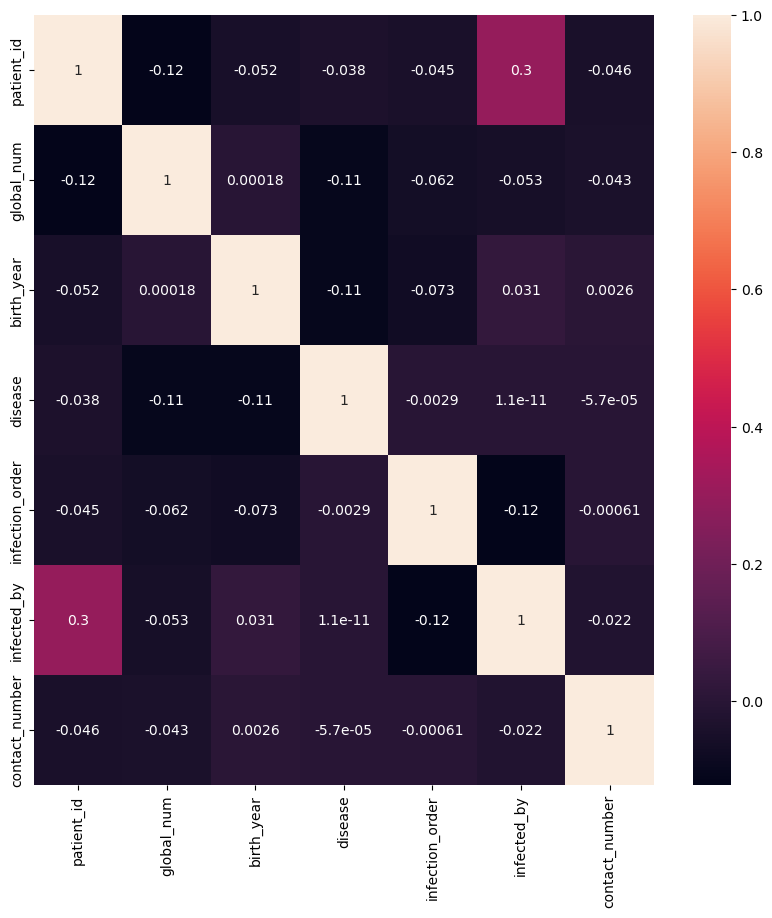

In [49]:
n_cols = ['n_age', 'n_sex', 'n_ctry', 'n_prov', 'n_city', 'n_icase' ]

fig, ax = plt.subplots(figsize = (10,10))

dfn = df.select_dtypes( exclude=['datetime', 'object'])
corr = dfn.drop(n_cols, axis=1).corr()
sns.heatmap(corr, annot=True)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

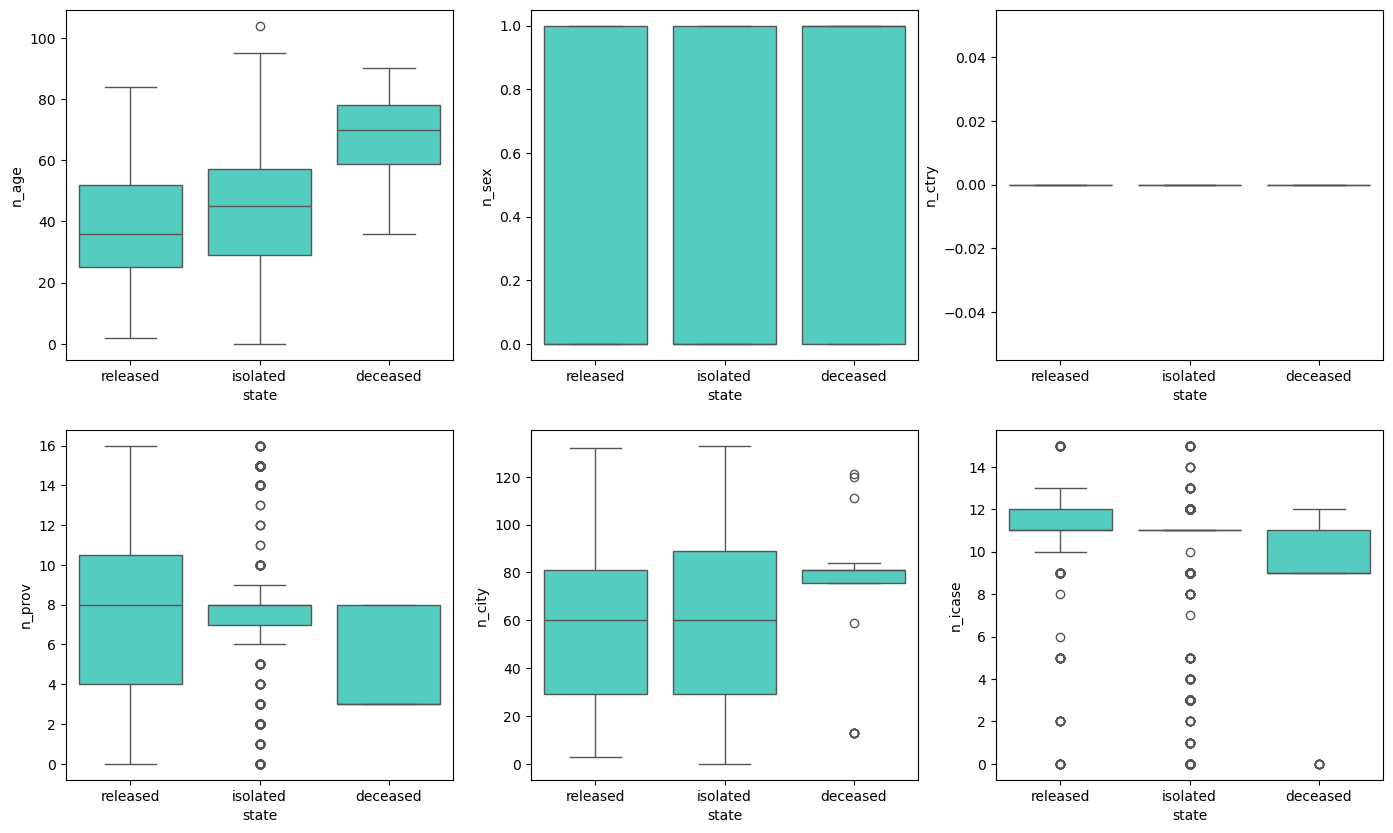

In [50]:
fig, axs = plt.subplots(2,3, figsize=(17,10))
irow = jcol = 0

for i, col in enumerate(n_cols,0): 
    if i <=2:
        irow=0
    else: 
        irow=1
        
    if jcol == 3:
        jcol = 0
        
    sns.boxplot(x='state', y=col, data=df_cp, ax=axs[irow, jcol], color='turquoise')    # Note: df_cp contains NaN rows
    jcol+=1
    

**<font color='teal'> Create dummy features for object type features. </font>**

In [51]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age', 'n_sex', 'n_ctry',
       'n_prov', 'n_city', 'n_icase'],
      dtype='object')

In [52]:
# Drop columns under cols_to_drop including the target, state. . 
# Also drop all null rows and store result in df_exclstate which contains the features of interest.

cols_to_drop = ['state', 'n_age', 'n_sex', 'n_ctry', 'n_prov', 'n_city', 'n_icase']
df_exclstate = df.dropna( axis=0, how='any').drop(cols_to_drop, axis=1)

cols_to_drop.remove('state')
# Apply get_dummies to convert categorical observations to columns. 
X = pd.get_dummies(df_exclstate)
print('X shape:', X.shape)

# Obtain only state rows for label
df_states = df.dropna(axis=0, how='any').drop(cols_to_drop, axis=1)
y = df_states.loc[:, 'state']
print('y shape:', y.shape)

X shape: (2130, 188)
y shape: (2130,)


### Split the data into test and train subsamples

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [54]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [56]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.864
Random Forest: f1-score=0.846


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [57]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0]
 [  0 349  16]
 [  0  41  13]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.96 0.04]
 [0.   0.76 0.24]]


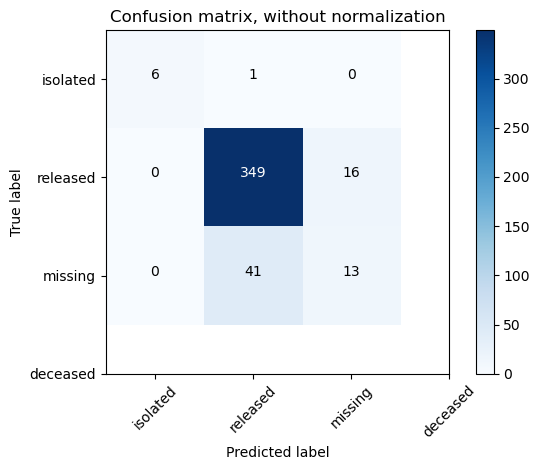

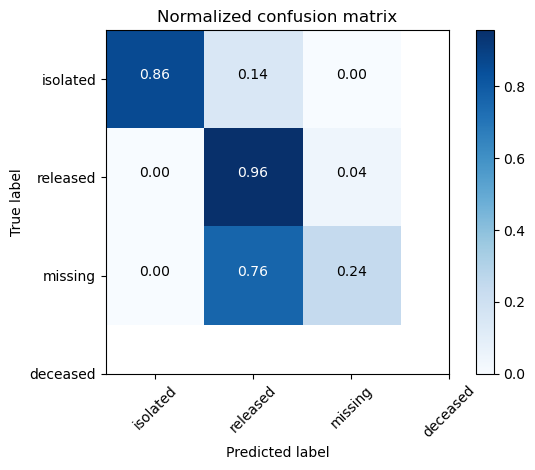

In [58]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


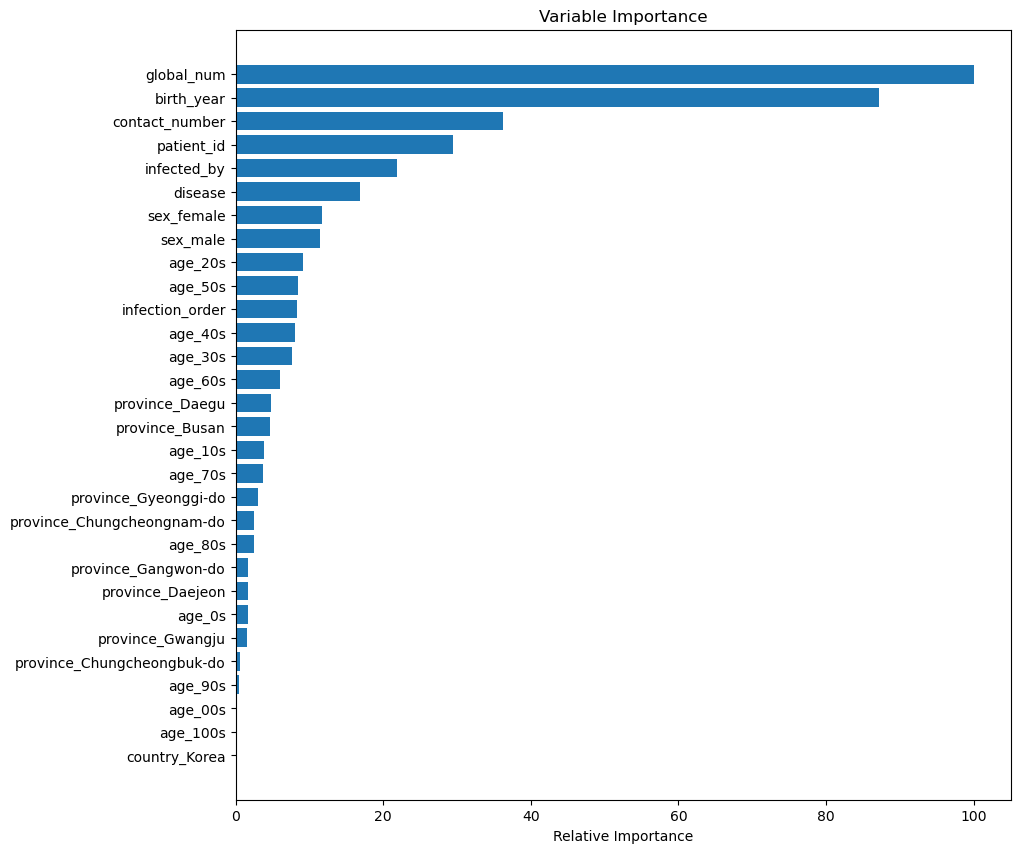

In [59]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.